In [1]:
% 1D profile: sensitivity
% two sensors: determinant plot
% large: for more number of sensors

% use pre-computed matrix for iteration
clear;
close all;

G_solution = 4215; % INPUT [kg/m2/s]
heat_flux_source = 852*1000; % INPUT [W/m2]
T_inlet_uniform = 300; % [K]

## geometry

In [2]:
L_channel = 0.056; % [m] flow length

## number grid

In [3]:
N_x_1 = 300+1; % INPUT total number of liquid grid points (including both ends) in x-direction
N_z = 100+1; % INPUT number of grid points (including both ends: inlet and outlet) in z-direction
N_x_2 = 40+1; % INPUT for solid substrate (including both ends: interface and outer wall)
N_x_tot = N_x_1 + N_x_2 - 1;
N_y = 19; % INPUT number of grid points in width direction

z_grid = linspace(0, L_channel, N_z); % [m] distance from inlet
z_grid_mm = z_grid*1000;

## sensor location (use index\_y=1): all sensors

In [4]:
sensor_user_input = zeros(N_z-1,3); sensor_user_input(:,1) = 2:N_z; sensor_user_input(:,2) = N_x_1; sensor_user_input(:,3) = 1; % sensors all grid

## Phi: sensor index within the grid

In [5]:
sensor_index_z = sensor_user_input(:,1);
sensor_index_x = sensor_user_input(:,2);
sensor_index_y = sensor_user_input(:,3);
number_sensor = length(sensor_index_z);
sensor_index = sensor_index_z + (sensor_index_x-1)*N_z + (sensor_index_y-1)*N_z*N_x_tot; %

Phi_location_sensor = sparse(number_sensor, N_x_tot*N_z*N_y);
Phi_location_sensor_z = zeros(number_sensor, N_z);
for ids=1:size(sensor_index, 1)
    Phi_location_sensor(ids, sensor_index(ids)) = 1;
    Phi_location_sensor_z(ids, sensor_index_z(ids)) = 1;
end

## load precomputed calculations

In [6]:
G_floor = floor(G_solution/10)*10;
digit_thousands = floor(G_floor/1000);
digit_hundreds = floor((G_floor - digit_thousands*1000)/100);
digit_tens= floor((G_floor - digit_thousands*1000 - digit_hundreds*100)/10);
digit_ones= floor(G_floor - digit_thousands*1000 - digit_hundreds*100 - digit_tens*10);
inputname3      = ['./divisions_A_matrix_centerline/centerline_divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];
load(inputname3,'centerline_A_div_L_qbcs1');
f_10floor = [centerline_A_div_L_qbcs1];

G_ceil = ceil(sqrt(eps) + G_solution/10)*10;
digit_thousands = floor(G_ceil/1000);
digit_hundreds = floor((G_ceil - digit_thousands*1000)/100);
digit_tens= floor((G_ceil - digit_thousands*1000 - digit_hundreds*100)/10);
digit_ones= floor(G_ceil - digit_thousands*1000 - digit_hundreds*100 - digit_tens*10);
inputname4      = ['./divisions_A_matrix_centerline/centerline_divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];
load(inputname4,'centerline_A_div_L_qbcs1');
f_10ceil = [centerline_A_div_L_qbcs1];

if G_floor == G_solution % no interpolation
    centerline_A_div_L_qbcs1 = f_10floor;
else % interpolation
    f_interp = f_10floor + (f_10ceil-f_10floor)/(G_ceil-G_floor)*(G_solution-G_floor);
    centerline_A_div_L_qbcs1 = f_interp;
end

T_sensing_10floor = Phi_location_sensor_z*(f_10floor*heat_flux_source + T_inlet_uniform);
T_sensing_10ceil = Phi_location_sensor_z*(f_10ceil*heat_flux_source + T_inlet_uniform);
if G_floor == G_solution
    dT_sensing = T_sensing_10floor - T_inlet_uniform;
else
    dT_sensing = T_sensing_10floor + (T_sensing_10ceil - T_sensing_10floor)/(G_ceil - G_floor)*(G_solution - G_floor) - T_inlet_uniform;
end

## derivation of noise ellipse

In [7]:
b_vector1 = Phi_location_sensor_z*centerline_A_div_L_qbcs1;
b_vector1 = full(b_vector1);
b_vector2 = (T_sensing_10ceil - T_sensing_10floor)/10;

H = zeros(number_sensor, 2); % 2 is number of parameter

H(:,1) = b_vector1*1000; % first column for Q[kW]
H(:,2) = b_vector2; % second column for G

% for each measurement point, calculate its impact through trace: H_mQ^2+H_mG^2
trace_each_sensor = H(:,1).*H(:,1) + H(:,2).*H(:,2);

% for determinant
H_QQ = H(:,1).*H(:,1); % QQ
H_GG = H(:,2).*H(:,2); % GG
H_QG = H(:,1).*H(:,2); % QG

In [8]:
fprintf("one\n")

one

In [9]:
tr_one_sensor = NaN(N_z-1,1);
for i=1:N_z-1
    tr_one_sensor(i) = H_QQ(i) + H_GG(i);
end

one_id1_max = find(tr_one_sensor == max(tr_one_sensor));

In [10]:
fprintf("two\n")

two

In [11]:
det_two_sensors = NaN(N_z-1);
for i=1:N_z-1
    for j=i+1:N_z-1
        det_two_sensors(i, j) = (H_QQ(i)+H_QQ(j))*(H_GG(i)+H_GG(j)) - (H_QG(i)+H_QG(j))^2;
    end
end

[two_id1_max, two_id2_max] = ind2sub(size(det_two_sensors), find(det_two_sensors == max(det_two_sensors(:))));
% notation: [I1,I2,I3] = ind2sub(sz, ind)
T_sigma = 0.1; % INPUT [K] noise magnitude
confidence_interval = 0.95; % INPUT confidence interval
scale_ellipsoid = -2*log(1 - confidence_interval); % equal to chi2inv(p, 2)
area_ellipse_two_sensors = pi*T_sigma*sqrt(scale_ellipsoid)./sqrt(det_two_sensors);
log_area_ellipse_two_sensors = log10(area_ellipse_two_sensors);
min_log_area_ellipse_two_sensors = min(log_area_ellipse_two_sensors,[],'all');

In [12]:
fprintf("three\n")

three

In [13]:
det_three_sensors = NaN(N_z-1,N_z-1,N_z-1);
for i=1:N_z-1
    for j=i+1:N_z-1
        for k=j+1:N_z-1
            det_three_sensors(i, j, k) = (H_QQ(i)+H_QQ(j)+H_QQ(k))*(H_GG(i)+H_GG(j)+H_GG(k)) - (H_QG(i)+H_QG(j)+H_QG(k))^2;
        end
    end
end
[three_id1_max, three_id2_max, three_id3_max] = ind2sub(size(det_three_sensors), find(det_three_sensors == max(det_three_sensors(:))));
area_ellipse_three_sensors = pi*T_sigma*sqrt(scale_ellipsoid)./sqrt(det_three_sensors);
log_area_ellipse_three_sensors = log10(area_ellipse_three_sensors);
min_log_area_ellipse_three_sensors = min(log_area_ellipse_three_sensors,[],'all');

## this method is acceptable upto four dimension (RAM)

In [14]:
fprintf("four\n")

four

In [15]:
det_four_sensors = NaN(N_z-1,N_z-1,N_z-1,N_z-1);
for i=1:N_z-1
    for j=i+1:N_z-1
        for k=j+1:N_z-1
            for l=k+1:N_z-1
                det_four_sensors(i, j, k, l) = (H_QQ(i)+H_QQ(j)+H_QQ(k)+H_QQ(l))*(H_GG(i)+H_GG(j)+H_GG(k)+H_GG(l)) - (H_QG(i)+H_QG(j)+H_QG(k)+H_QG(l))^2;
            end
        end
    end
end
[four_id1_max, four_id2_max, four_id3_max, four_id4_max] = ind2sub(size(det_four_sensors), find(det_four_sensors == max(det_four_sensors(:))));
area_ellipse_four_sensors = pi*T_sigma*sqrt(scale_ellipsoid)./sqrt(det_four_sensors);
log_area_ellipse_four_sensors = log10(area_ellipse_four_sensors);
min_log_area_ellipse_four_sensors = min(log_area_ellipse_four_sensors,[],'all');

In [16]:
fprintf("five\n")

five

In [17]:
combinations = nchoosek(1:N_z-1, 5);
det_five_sensors = zeros(size(combinations, 1), 1);
for idx = 1:size(combinations, 1)
    i = combinations(idx, 1);
    j = combinations(idx, 2);
    k = combinations(idx, 3);
    l = combinations(idx, 4);
    m = combinations(idx, 5);
    det_five_sensors(idx) = (H_QQ(i) + H_QQ(j) + H_QQ(k) + H_QQ(l) + H_QQ(m)) * ...
                      (H_GG(i) + H_GG(j) + H_GG(k) + H_GG(l) + H_GG(m)) - ...
                      (H_QG(i) + H_QG(j) + H_QG(k) + H_QG(l) + H_QG(m))^2;
end

[max_det, max_idx] = max(det_five_sensors); % Find the indices of the maximum determinant
five_indices = combinations(max_idx, :); % Extract the corresponding indices i, j, k, l, m
area_ellipse_five_sensors = pi*T_sigma*sqrt(scale_ellipsoid)./sqrt(det_five_sensors);
log_area_ellipse_five_sensors = log10(area_ellipse_five_sensors);
min_log_area_ellipse_five_sensors = min(log_area_ellipse_five_sensors,[],'all');

## use function

In [18]:
[six_indices, min_log_area_ellipse_six_sensors] = ...
    suboptimum_sensor_location_f(five_indices, T_sigma, scale_ellipsoid, H_QQ, H_GG, H_QG);

6

In [19]:

[seven_indices, min_log_area_ellipse_seven_sensors] = ...
    suboptimum_sensor_location_f(six_indices, T_sigma, scale_ellipsoid, H_QQ, H_GG, H_QG);

7

In [20]:

[eight_indices, min_log_area_ellipse_eight_sensors] = ...
    suboptimum_sensor_location_f(seven_indices, T_sigma, scale_ellipsoid, H_QQ, H_GG, H_QG);

8

## towards all number sensors

In [21]:
n_finish = N_z-2; % INPUT (###_indices) above 6. up to N_z-2
% Initialize cell arrays to store indices and results
indices_cell = cell(1, n_finish-5);  % To store indices for 6 to 100 (total 95 iterations)
min_log_ellipse_area_cell = cell(1, n_finish-5);  % To store min log area ellipses for each sensor count

% Initialize the starting indices (six_indices in your case)
indices_cell{1} = six_indices;

min_log_ellipse_area_summary = zeros(n_finish,1); % 2 to n_finish+1

% Iterate from 6 to 100 sensor count
for ni = 6:n_finish
    % Call the function and store the results in cell arrays
    [new_indices, min_log_area_ellipse] = suboptimum_sensor_location_f(indices_cell{ni - 5}, T_sigma, scale_ellipsoid, H_QQ, H_GG, H_QG);
    % Store results in respective cell arrays
    indices_cell{ni - 5 + 1} = new_indices;  % store in next cell. So up to N_z-2
    min_log_ellipse_area_cell{ni - 5 + 1} = min_log_area_ellipse;
    min_log_ellipse_area_summary(ni) = min_log_area_ellipse;
end

7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100

In [22]:

% summary from previous searches
min_log_ellipse_area_summary(1) = min_log_area_ellipse_two_sensors;
min_log_ellipse_area_summary(2) = min_log_area_ellipse_three_sensors;
min_log_ellipse_area_summary(3) = min_log_area_ellipse_four_sensors;
min_log_ellipse_area_summary(4) = min_log_area_ellipse_five_sensors;
min_log_ellipse_area_summary(5) = min_log_area_ellipse_six_sensors;

In [23]:
fprintf("all\n")

all

In [24]:
det_all_sensors = sum(H_QQ)*sum(H_GG)-sum(H_QG)^2;
area_ellipse_all_sensors = pi*T_sigma*sqrt(scale_ellipsoid)./sqrt(det_all_sensors);
log_area_ellipse_all_sensors = log10(area_ellipse_all_sensors);
min_log_area_ellipse_all_sensors = min(log_area_ellipse_all_sensors, [],'all');


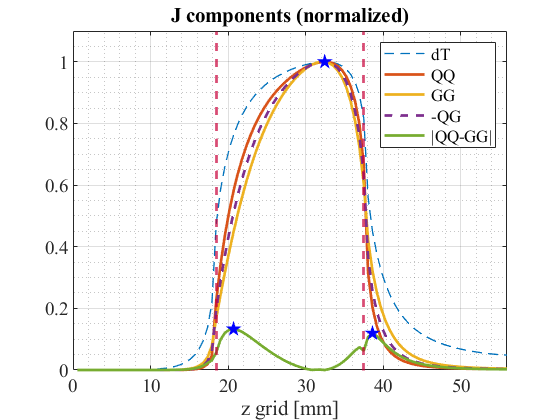

In [25]:
pixel_heater_start = 34;
pixel_heater_end = 68;

figure(1) % + 1 to be on z grid index
set(gcf, 'WindowState', 'maximized');
plot(z_grid_mm(2:end), dT_sensing/max(dT_sensing),'--','Linewidth',1,'displayname',' dT')
hold on
plot(z_grid_mm(2:end), H_QQ/max(H_QQ),'Linewidth',2,'displayname',' QQ')
hold on
plot(z_grid_mm(2:end), H_GG/max(H_GG),'Linewidth',2,'displayname',' GG')
hold on
plot(z_grid_mm(2:end), -H_QG/max(abs(H_QG)),'--','Linewidth',2,'displayname',' -QG')
hold on
plot(z_grid_mm(2:end), abs((H_QQ/max(H_QQ))-(H_GG/max(H_GG))),'Linewidth',2,'displayname',' |QQ-GG|')
hold on
xline(z_grid_mm(pixel_heater_start),'--','Linewidth',2,'color','#C70039','handlevisibility','off')
hold on
xline(z_grid_mm(pixel_heater_end),'--','Linewidth',2,'color','#C70039','handlevisibility','off')

hold on
pentagram_size = 100; % 40, 100
[dT_sensing_max, dT_sensing_max_id] = max(dT_sensing); % maximum temperature
scatter(z_grid_mm(dT_sensing_max_id+1), 1/1, pentagram_size,'pentagram','MarkerFaceColor','blue','MarkerEdgeColor','blue','handlevisibility','off')

QQ_GG = (H_QQ/max(H_QQ))-(H_GG/max(H_GG));
[QQ_GG_max, QQ_GG_max_id] = max(QQ_GG);
[QQ_GG_min, QQ_GG_min_id] = min(QQ_GG);
hold on
scatter(z_grid_mm(QQ_GG_max_id+1), QQ_GG(QQ_GG_max_id), pentagram_size,'pentagram','MarkerFaceColor','blue','MarkerEdgeColor','blue','handlevisibility','off')
hold on
scatter(z_grid_mm(QQ_GG_min_id+1), abs(QQ_GG(QQ_GG_min_id)), pentagram_size,'pentagram','MarkerFaceColor','blue','MarkerEdgeColor','blue','handlevisibility','off')

legend('show')
xlabel('z grid [mm]')
xlim([0 z_grid_mm(end)])
ylim([0 1.1])
title("J components (normalized)")
set(gca,'FontSize',14,'fontname','times')
grid on
grid minor

## sensor locations


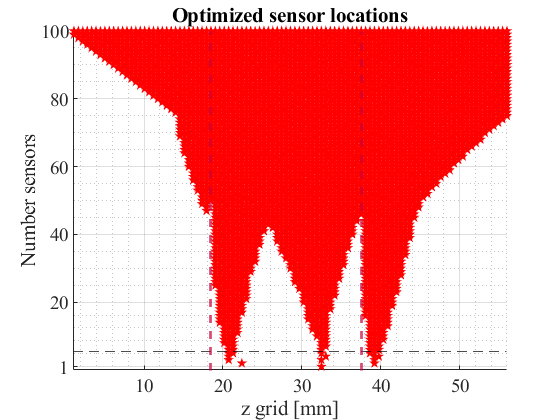

In [26]:
figure(2)
set(gcf, 'WindowState', 'maximized');
% subplot(1,2,1)
scatter(z_grid_mm([one_id1_max]+1), [1],'pentagram','MarkerFaceColor','red','MarkerEdgeColor','red')
hold on
scatter(z_grid_mm([two_id1_max, two_id2_max]+1), [2,2],'pentagram','MarkerFaceColor','red','MarkerEdgeColor','red')
hold on
scatter(z_grid_mm([three_id1_max, three_id2_max, three_id3_max]+1), [3,3,3],'pentagram','MarkerFaceColor','red','MarkerEdgeColor','red')
hold on
scatter(z_grid_mm([four_id1_max, four_id2_max, four_id3_max, four_id4_max]+1), [4,4,4,4],'pentagram','MarkerFaceColor','red','MarkerEdgeColor','red')
hold on
scatter(z_grid_mm(five_indices+1), [5,5,5,5,5],'pentagram','MarkerFaceColor','red','MarkerEdgeColor','red')
hold on
scatter(z_grid_mm(six_indices+1), [6,6,6,6,6,6],'pentagram','MarkerFaceColor','red','MarkerEdgeColor','red')
hold on
yline(5.5,'k--')
hold on
for ni=6:n_finish
    scatter(z_grid_mm(indices_cell{ni - 5 + 1}+1), (ni+1)*ones(ni+1,1),'pentagram','MarkerFaceColor','red','MarkerEdgeColor','red')
    hold on
end
hold on
xline(z_grid_mm(pixel_heater_start),'--','Linewidth',2,'color','#C70039','handlevisibility','off')
hold on
xline(z_grid_mm(pixel_heater_end),'--','Linewidth',2,'color','#C70039','handlevisibility','off')

xlabel('z grid [mm]')
ylabel('Number sensors')
xlim([1 z_grid_mm(end)])
yticks([1,20,40,60,80,100]);
title("Optimized sensor locations")
set(gca,'FontSize', 14,'fontname','times')
grid on
grid minor


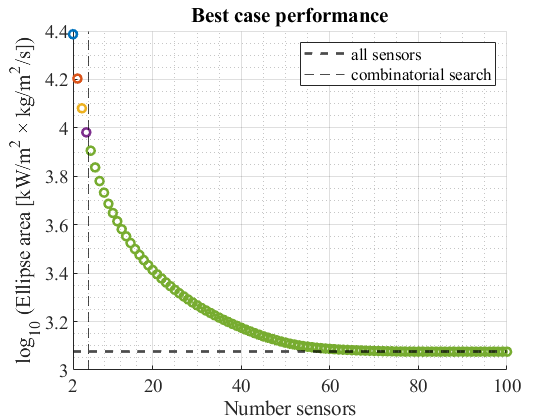

In [27]:

figure(3)
% summary best ellipse statistics
% subplot(1,2,2)
scatter(2, min_log_ellipse_area_summary(1),'Linewidth',2,'handlevisibility','off')
hold on
scatter(3, min_log_ellipse_area_summary(2),'Linewidth',2,'handlevisibility','off')
hold on
scatter(4, min_log_ellipse_area_summary(3),'Linewidth',2,'handlevisibility','off')
hold on
scatter(5, min_log_ellipse_area_summary(4),'Linewidth',2,'handlevisibility','off')
hold on
scatter(6:(n_finish+1), min_log_ellipse_area_summary(5:end),'Linewidth',2,'handlevisibility','off')
hold on
yline(min_log_area_ellipse_all_sensors,'k--','Linewidth',2,'displayname',' all sensors')
hold on
xline(5.5,'k--','displayname',' combinatorial search')

legend('show','location','northeast')
xlabel('Number sensors')
ylabel('log_{10} (Ellipse area [kW/m^2 × kg/m^2/s])')
title("Best case performance")
set(gca,'FontSize', 14,'fontname','times')
xlim([2 inf])
xticks([2,20,40,60,80,100]);
grid on
grid minor

## two sensor visualization


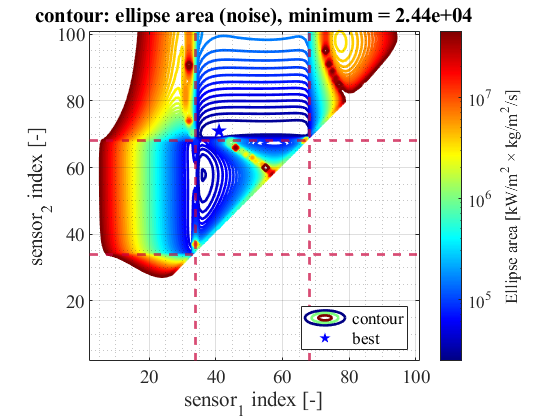

In [28]:
log_min_two_sensors = min(log_area_ellipse_two_sensors(:));
log_max_two_sensors = max(log_area_ellipse_two_sensors(:));

contour_levels_two = logspace(log_min_two_sensors, log_max_two_sensors/2, 50);

pixel_heater_start = 34;
pixel_heater_end = 68;

figure(4)
set(gcf, 'WindowState', 'maximized');
contour(2:N_z, 2:N_z, area_ellipse_two_sensors', contour_levels_two,'Linewidth',2,'displayname',' contour')
hold on
scatter(two_id1_max+1, two_id2_max+1, 100,'pentagram','MarkerFaceColor','blue','MarkerEdgeColor','blue','displayname',' best')
hold on
xline(pixel_heater_start,'--','Linewidth',2,'color','#C70039','handlevisibility','off')
hold on
xline(pixel_heater_end,'--','Linewidth',2,'color','#C70039','handlevisibility','off')
hold on
yline(pixel_heater_start,'--','Linewidth',2,'color','#C70039','handlevisibility','off')
hold on
yline(pixel_heater_end,'--','Linewidth',2,'color','#C70039','handlevisibility','off')
legend('show','location','southeast')
h1 = colorbar('eastoutside');  % Create a horizontal colorbar below the plot
h1.Label.String = 'Ellipse area [kW/m^2 × kg/m^2/s]';
colormap(jet)
xlabel('sensor_1 index [-]')
ylabel('sensor_2 index [-]')
xlim([2 101]) % N_z = 101
ylim([2 101])
caxis([10^log_min_two_sensors 10^(log_max_two_sensors/2)])
titleStr = sprintf('contour: ellipse area (noise), minimum = %.2e', ...
                   10^log_min_two_sensors);
title(titleStr);
set(gca,'FontSize',14,'fontname','times')
set(gca,'ColorScale','log')
axis square;
grid on
grid minor

## log area


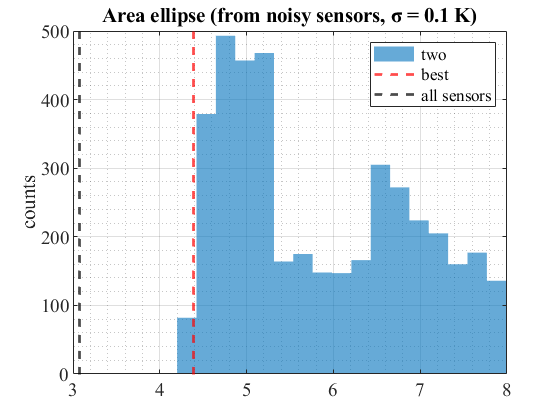

In [29]:
figure(5)
fontsize = 14;
set(gcf, 'WindowState', 'maximized');
numBins = 50; % Specify the number of bins
plot_x_start = 3;
plot_x_end = 8;

% subplot(4,1,1)
histogram(log_area_ellipse_two_sensors, numBins,'Normalization','count','EdgeColor', 'none', 'FaceColor', '#0072BD','displayname',' two')
hold on
xline(min(log_area_ellipse_two_sensors,[],'all'),'--r','Linewidth',2,'displayname',' best')
hold on
xline(log_area_ellipse_all_sensors,'--k','Linewidth',2,'displayname',' all sensors')
xlim([plot_x_start plot_x_end])
% ylim([0 0.05])
legend('show','location','northeast')
ylabel('counts')
titleStr = sprintf('Area ellipse (from noisy sensors, σ = %1.1f K)',T_sigma);
title(titleStr);

set(gca,'FontSize',fontsize,'fontname','times')
grid on
grid minor


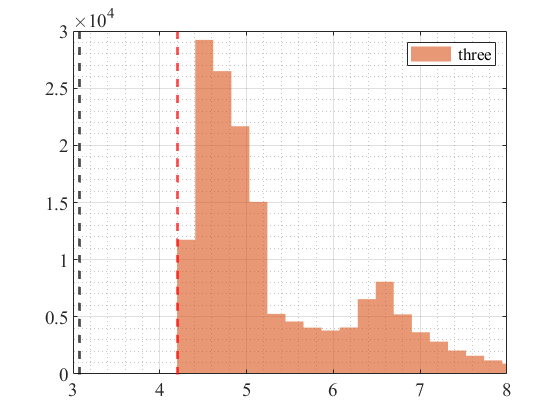

In [30]:

figure(6)
% subplot(4,1,2)
histogram(log_area_ellipse_three_sensors, numBins,'Normalization','count','EdgeColor', 'none', 'FaceColor', '#D95319','displayname',' three')
hold on
xline(min(log_area_ellipse_three_sensors,[],'all'),'--r','Linewidth',2,'handlevisibility','off')
hold on
xline(log_area_ellipse_all_sensors,'--k','Linewidth',2,'handlevisibility','off')
xlim([plot_x_start plot_x_end])
% ylim([0 0.05])
legend('show')
% ylabel('count')
set(gca,'FontSize',fontsize,'fontname','times')
grid on
grid minor


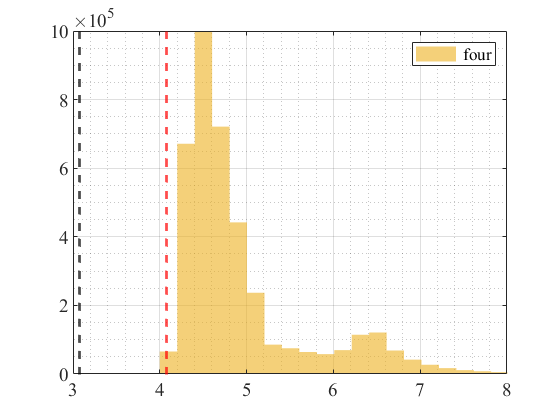

In [31]:

figure(7)
% subplot(4,1,3)
histogram(log_area_ellipse_four_sensors, numBins, 'Normalization','count','EdgeColor', 'none', 'FaceColor', '#EDB120','displayname',' four')
hold on
xline(min(log_area_ellipse_four_sensors,[],'all'),'--r','Linewidth',2,'handlevisibility','off')
hold on
xline(log_area_ellipse_all_sensors,'--k','Linewidth',2,'handlevisibility','off')
xlim([plot_x_start plot_x_end])
% ylim([0 0.05])
legend('show')
% ylabel('count')
set(gca,'FontSize',fontsize,'fontname','times')
grid on
grid minor


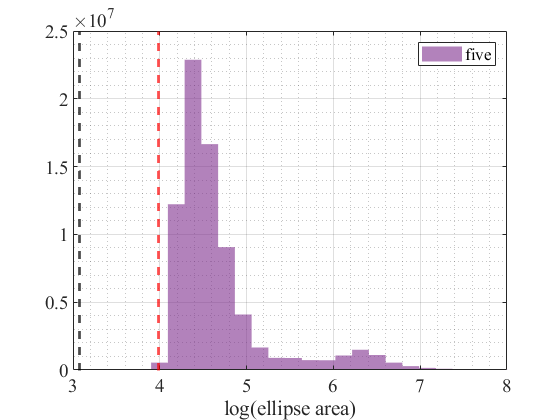

In [32]:

figure(8)
% subplot(4,1,4)
histogram(log_area_ellipse_five_sensors, numBins, 'Normalization','count','EdgeColor', 'none', 'FaceColor', '#7E2F8E','displayname',' five')
hold on
xline(min(log_area_ellipse_five_sensors,[],'all'),'--r','Linewidth',2,'handlevisibility','off')
hold on
xline(log_area_ellipse_all_sensors,'--k','Linewidth',2,'handlevisibility','off')
xlabel('log(ellipse area)')
% ylabel('count')
xlim([plot_x_start plot_x_end])
% ylim([0 0.3])
legend('five')
set(gca,'FontSize',fontsize,'fontname','times')
grid on
grid minor